In [2]:
from langgraph.graph import StateGraph, START,END 
from typing import TypedDict, Literal , Annotated
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel, Field
from typing import TypedDict,Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("GEMINI_API_KEY")
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite",
                               api_key=api_key)



In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite",
                               api_key=api_key)

In [4]:
class TweetEvaluation(BaseModel):
    evaluation : Literal["Approved" , "Needs_Improvement"]= Field(description="final evaluation of the tweet")
    feedback : str = Field(description="feedback on the tweet")

In [5]:
evaluation_model = model.with_structured_output(TweetEvaluation)

In [6]:
# define the state

class TweetState(TypedDict):
    topic : str
    tweet : str
    feedback : str
    evaluation : Literal["Approved" , "Needs_Improvement"] 
    iterations : int 

In [7]:
def generate_tweet(state: TweetState) -> TweetState:
    messages = [
    SystemMessage(content="You are a funny and clever Twitter/X influencer."),
    HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
    
Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
]


    response = model(messages).content
    return {"tweet": response}

In [8]:
def evaluate_tweet(state: TweetState) -> TweetState:
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?
2. Humor – Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness – Is it short, sharp, and scroll-stopping?
4. Virality Potential – Would people retweet or share it?
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Don't end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
- feedback: One paragraph explaining the strengths and weaknesses
""")
]
    
    response = evaluation_model.invoke(messages)
    return {"evaluation": response.evaluation, "feedback": response.feedback}
    


In [9]:
def optimize_tweet(state: TweetState) -> TweetState:
     messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
     iterations =  state["iterations"] + 1 
     response = model(messages).content
     return {"tweet": response, "iterations": iterations }

In [10]:
def check_condition(state: TweetState):
    if state['evaluation'] == "Approved" or  state["iterations"] >=5:
        return  "Approved"
    else:
        return "Needs_Improvement"

In [11]:
Graph  =  StateGraph(TweetState)

Graph.add_node("generate_tweet",generate_tweet)
Graph.add_node("evaluate_tweet",evaluate_tweet)
Graph.add_node("optimize_tweet",optimize_tweet)


Graph.add_edge(START,"generate_tweet")
Graph.add_edge("generate_tweet","evaluate_tweet")
Graph.add_conditional_edges("evaluate_tweet", check_condition,{"Approved":END, "Needs_Improvement" : "optimize_tweet"})
Graph.add_edge("optimize_tweet","evaluate_tweet")


In [12]:
workflow  = Graph.compile()

In [24]:
initial_state  = {"topic": "asssfsdd" ,
                  "evaluation": "Needs_Improvement",
                  "iterations": 0}

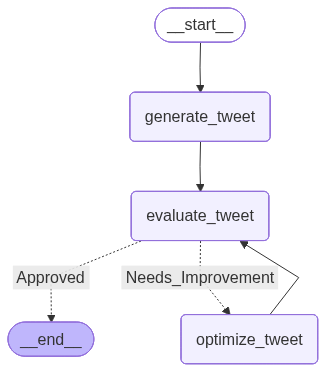

In [14]:
workflow

In [25]:
workflow.invoke(initial_state)


{'topic': 'asssfsdd',
 'tweet': 'Brain: "asssfsdd"\n\nMe: *stares at the fridge, forgetting why I\'m there.*\n\nBrain: *starts a new, unrelated thought.*\n\nMy brain is a chaotic good villain. #adhd #brainfog #relatable',
 'feedback': "This tweet is pretty good. The format is solid, the humor is relatable, and the punchiness is there. The originality isn't off the charts, but the relatability factor gives it some virality potential. Overall, a decent effort that probably won't bomb.",
 'evaluation': 'Approved',
 'iterations': 3}